# Unsupervised Capstone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

raw_data = pd.read_csv('./applestore.csv', index_col=0)
raw_data.drop(columns=['id', 'track_name', 'currency'], inplace=True)
print(raw_data.shape)
print(list(raw_data.columns))
raw_data.head()

(7197, 13)
['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'ver', 'cont_rating', 'prime_genre', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'vpp_lic']


,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
1,100788224,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
2,158578688,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
3,100524032,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
4,128512000,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
5,92774400,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [2]:
hobby_lifestyle_genres = ['Sports', 'Photo & Video', 'Book', 'Games', 'Music', 'News', 'Lifestyle', 'Health & Fitness', 'Food & Drink', 'Shopping', 'Travel', 'Entertainment']
utility_genres = ['Productivity', 'Weather', 'Finance', 'Utilities', 'Navigation', 'Medical', 'Reference']
social_genres = ['Social Networking']
other_genres = ['Education', 'Business', 'Catalogs']

def get_prime_genre(genre):
    if genre in hobby_lifestyle_genres:
        return 'Hobby or Lifestyle'
    elif genre in utility_genres:
        return 'Utility'
    elif genre in social_genres:
        return 'Social'
    elif genre in other_genres:
        return 'Other'

df = raw_data.copy()
df['prime_genre'] = df['prime_genre'].apply(get_prime_genre)

df = df[df['prime_genre'] != 'Other']
df['prime_genre'].value_counts()

Hobby or Lifestyle    5775
Utility                735
Social                 167
Name: prime_genre, dtype: int64

In [3]:
for col in df.columns:
    print(col, '-', len(df[col].unique()), 'uniq vals')
    if col in ['price']:
        print('     ', sorted(df[col].unique()))

size_bytes - 6603 uniq vals
price - 33 uniq vals
      [0.0, 0.99, 1.99, 2.99, 3.99, 4.99, 5.99, 6.99, 7.99, 8.99, 9.99, 11.99, 12.99, 13.99, 14.99, 15.99, 16.99, 17.99, 18.99, 19.99, 20.99, 21.99, 22.99, 23.99, 24.99, 27.99, 29.99, 34.99, 39.99, 47.99, 49.99, 74.99, 99.99]
rating_count_tot - 3072 uniq vals
rating_count_ver - 1119 uniq vals
user_rating - 10 uniq vals
user_rating_ver - 10 uniq vals
ver - 1540 uniq vals
cont_rating - 4 uniq vals
prime_genre - 3 uniq vals
sup_devices.num - 20 uniq vals
ipadSc_urls.num - 6 uniq vals
lang.num - 57 uniq vals
vpp_lic - 2 uniq vals


size_bytes
   Avg: 201779103.11
   Median: 96720896.0
price
   Avg: 1.54
   Median: 0.0
rating_count_tot
   Avg: 13701.61
   Median: 325.0
rating_count_ver
   Avg: 477.14
   Median: 25.0
user_rating
   Avg: 3.54
   Median: 4.0
user_rating_ver
   Avg: 3.28
   Median: 4.0
sup_devices.num
   Avg: 37.42
   Median: 37.0
ipadSc_urls.num
   Avg: 3.66
   Median: 5.0
lang.num
   Avg: 5.27
   Median: 1.0


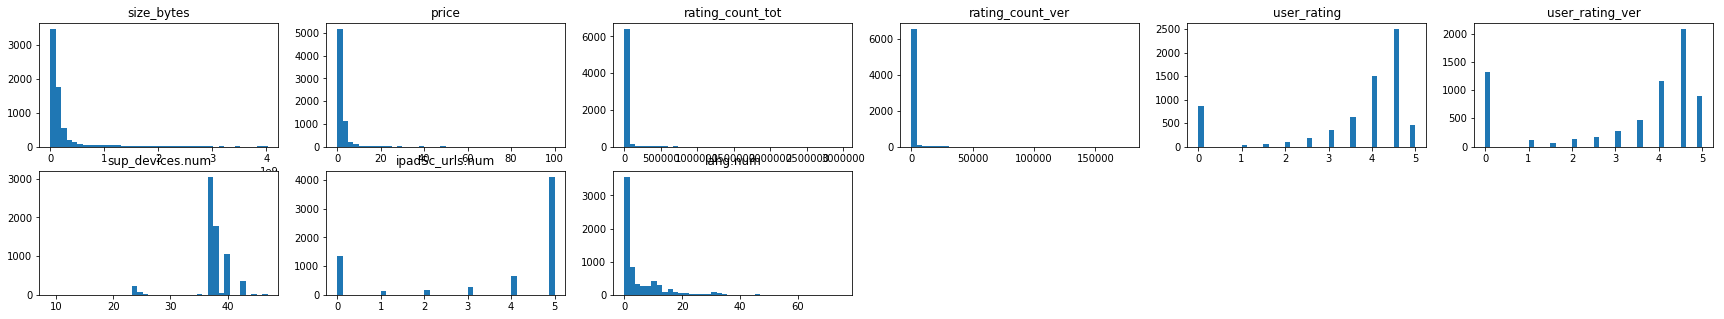

In [4]:
df['free'] = df['price'].apply(lambda x: 1 if x == 0 else 0)
df['high_rating'] = df['user_rating'] >= 4
df['high_rating_ver'] = df['user_rating_ver'] >= 4

continuous_cols = ['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num']

plt.figure(figsize=(30,5))

for idx, col in enumerate(continuous_cols):
    plt.subplot(2, 6, idx + 1)
    plt.hist(df[col], bins=40)
    plt.title(col)
    print(col)
    print('   Avg:', round(df[col].mean(), 2))
    print('   Median:', round(df[col].median(), 2))

plt.show()

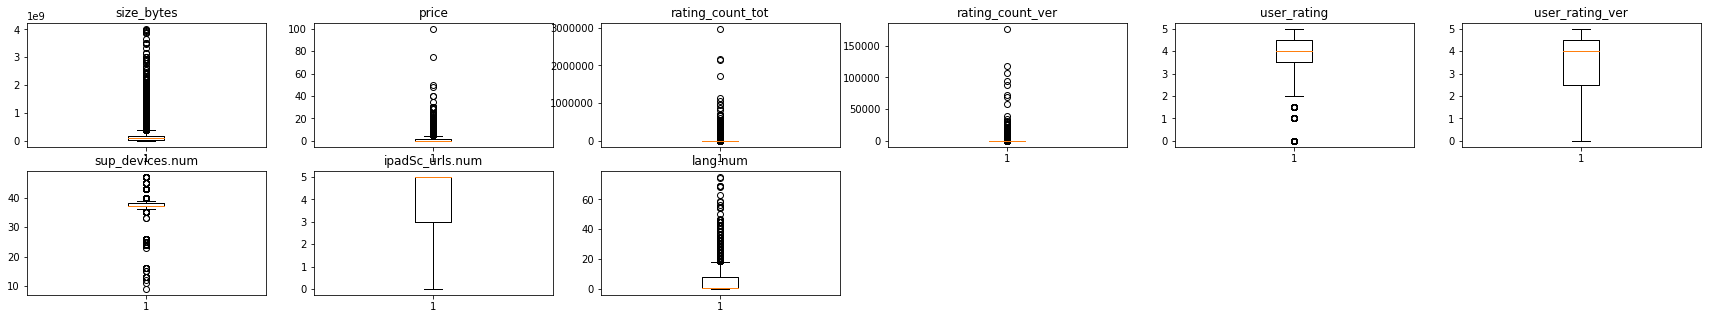

In [5]:
plt.figure(figsize=(30,5))

for idx, col in enumerate(continuous_cols):
    plt.subplot(2, 6, idx + 1)
    plt.boxplot(df[col])
    plt.title(col)

plt.show()

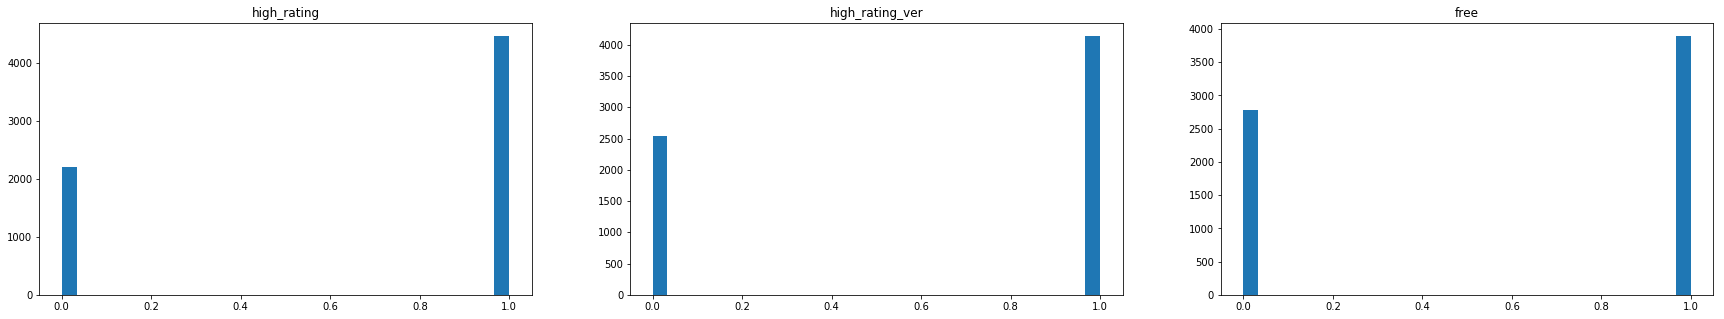

In [6]:
categ_cols = ['high_rating', 'high_rating_ver', 'free']

plt.figure(figsize=(30,5))

for idx, col in enumerate(categ_cols):
    plt.subplot(1, 3, idx + 1)
    plt.hist(df[col], bins=30)
    plt.title(col)

plt.show()

In [7]:
# df['size_small'] = df['size_bytes'].apply(lambda x: 1 if x <= df['size_bytes'].median() else 0)
df['major_v'] = df['ver'].str.extract('(\d+)', expand=False).str.split('.').apply(lambda x:x[0])
df['major_v'] = pd.to_numeric(df['major_v'], errors='coerce').fillna(0).astype(np.int64)

df['up_to_v_1'] = df['major_v'].apply(lambda x: 1 if x <= 1 else 0)

df.drop(columns=['ver', 'major_v'], inplace=True)
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic,free,high_rating,high_rating_ver,up_to_v_1
1,100788224,3.99,21292,26,4.0,4.5,4+,Hobby or Lifestyle,38,5,10,1,0,True,True,0
2,158578688,0.00,161065,26,4.0,3.5,4+,Utility,37,5,23,1,1,True,False,0
3,100524032,0.00,188583,2822,3.5,4.5,4+,Utility,37,5,3,1,1,False,True,0
4,128512000,0.00,262241,649,4.0,4.5,12+,Hobby or Lifestyle,37,5,9,1,1,True,True,0
5,92774400,0.00,985920,5320,4.5,5.0,4+,Utility,37,5,45,1,1,True,True,0


In [8]:
cols_to_dummify = ['cont_rating', 'prime_genre', 'vpp_lic', 'high_rating', 'high_rating_ver', 'up_to_v_1']
# 'size_small'

for col in cols_to_dummify:
    dummies = pd.get_dummies(df[col])
    for dummy in dummies:
        df[col + '_' + str(dummy)] = dummies[dummy]
    
    df.drop(columns=[col], inplace=True)
    
df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,free,...,prime_genre_Social,prime_genre_Utility,vpp_lic_0,vpp_lic_1,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
1,100788224,3.99,21292,26,4.0,4.5,38,5,10,0,...,0,0,0,1,0,1,0,1,1,0
2,158578688,0.00,161065,26,4.0,3.5,37,5,23,1,...,0,1,0,1,0,1,1,0,1,0
3,100524032,0.00,188583,2822,3.5,4.5,37,5,3,1,...,0,1,0,1,1,0,0,1,1,0
4,128512000,0.00,262241,649,4.0,4.5,37,5,9,1,...,0,0,0,1,0,1,0,1,1,0
5,92774400,0.00,985920,5320,4.5,5.0,37,5,45,1,...,0,1,0,1,0,1,0,1,1,0


In [9]:
cols_to_norm = continuous_cols

# Normalize data before clustering
df = df.dropna(subset=cols_to_norm)

cluster_df = df.copy()
cluster_df[cols_to_norm] = normalize(cluster_df[cols_to_norm])
    
cluster_df = pd.concat([cluster_df[cols_to_norm], cluster_df[cluster_df.columns.difference(cols_to_norm)]], axis=1)
print(cluster_df.shape[0], 'rows;', cluster_df.shape[1], 'columns')

cluster_df.head()
print(list(cluster_df.columns))

6677 rows; 25 columns
['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'sup_devices.num', 'ipadSc_urls.num', 'lang.num', 'cont_rating_12+', 'cont_rating_17+', 'cont_rating_4+', 'cont_rating_9+', 'free', 'high_rating_False', 'high_rating_True', 'high_rating_ver_False', 'high_rating_ver_True', 'prime_genre_Hobby or Lifestyle', 'prime_genre_Social', 'prime_genre_Utility', 'up_to_v_1_0', 'up_to_v_1_1', 'vpp_lic_0', 'vpp_lic_1']


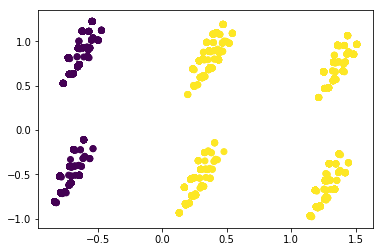

In [10]:
pca_2 = PCA(2).fit_transform(cluster_df)
kmeans_2_pred = KMeans(n_clusters=2, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_2_pred)
plt.show()

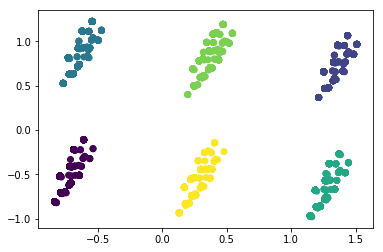

In [11]:
kmeans_6_pred = KMeans(n_clusters=6, random_state=10).fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=kmeans_6_pred)
plt.show()

Comparing k-means and mini batch k-means solutions:
col_0     0    1     2     3    4    5
row_0                                 
0         0  715     0     0  557    0
1         0    0  1515     0    0    0
2      2297    0     0     0    0    0
3         0    0     0     0    0  431
4         0    0     0  1044    0    0
5         0    0     0   118    0    0


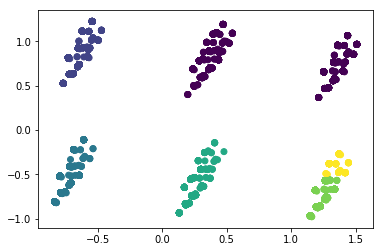

In [12]:
minibatchkmeans = MiniBatchKMeans(init='random', n_clusters=6, batch_size=200)
minibatchkmeans.fit(pca_2)

# Add the new predicted cluster memberships to the data frame.
mini_pred = minibatchkmeans.predict(pca_2)

# Check the MiniBatch model against our earlier one.
print('Comparing k-means and mini batch k-means solutions:')
print(pd.crosstab(mini_pred, kmeans_6_pred))

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=mini_pred)
plt.show()

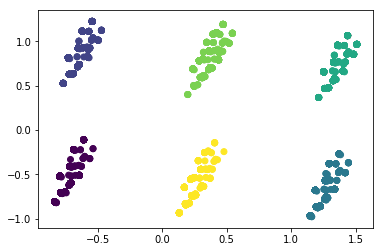

In [13]:
bandwidth = estimate_bandwidth(pca_2, quantile=0.2, n_samples=500)

ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
ms_pred = ms.fit_predict(pca_2)

plt.scatter(pca_2[:, 0], pca_2[:, 1], c=ms_pred)
plt.show()

In [14]:
df['kmeans_6_pred'] = kmeans_6_pred

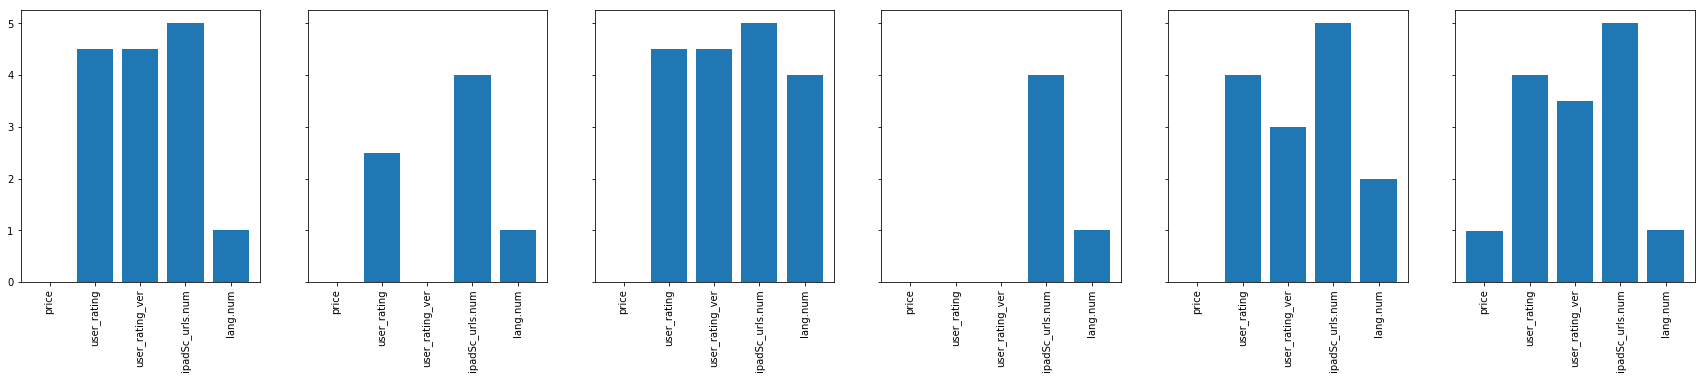

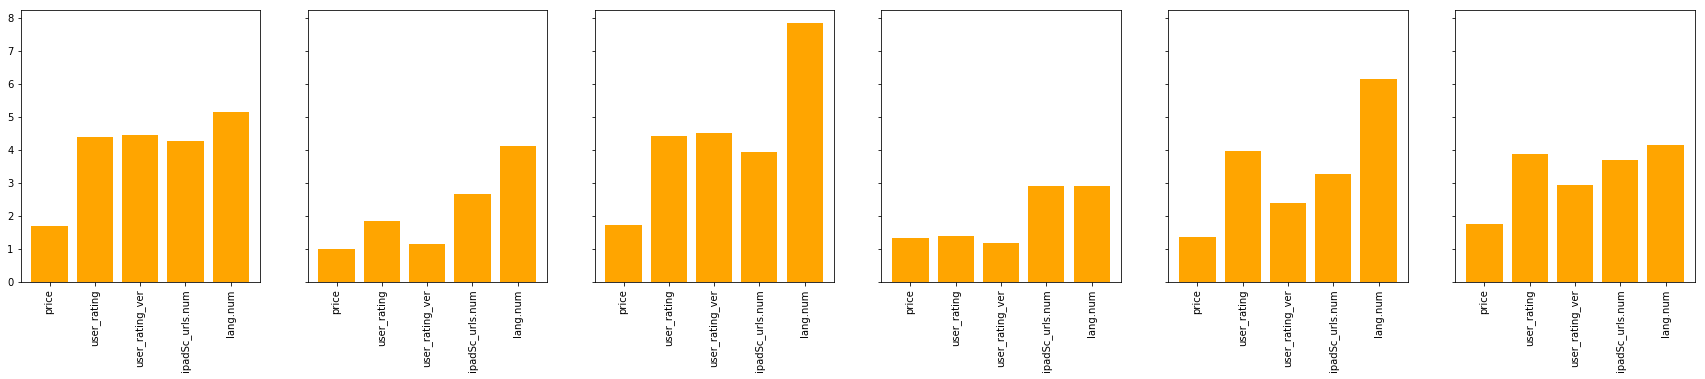

In [33]:
cluster_1 = df[df['kmeans_6_pred'] == 0].loc[:, df.columns != 'kmeans_6_pred']
cluster_2 = df[df['kmeans_6_pred'] == 1].loc[:, df.columns != 'kmeans_6_pred']
cluster_3 = df[df['kmeans_6_pred'] == 2].loc[:, df.columns != 'kmeans_6_pred']
cluster_4 = df[df['kmeans_6_pred'] == 3].loc[:, df.columns != 'kmeans_6_pred']
cluster_5 = df[df['kmeans_6_pred'] == 4].loc[:, df.columns != 'kmeans_6_pred']
cluster_6 = df[df['kmeans_6_pred'] == 5].loc[:, df.columns != 'kmeans_6_pred']
all_clusters = [cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6]

# MEDIANS
clusters_medians_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_medians_df.at[idx, col] = cluster[col].median()

cols_to_compare = ['price', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

f, axes = plt.subplots(1, 6, sharey=True, figsize=(30, 5))

for rowIdx in range(6):
    cluster = clusters_medians_df.iloc[rowIdx,:]
    axes[rowIdx].bar(cluster[cols_to_compare].index, height=cluster[cols_to_compare])

    for tick in axes[rowIdx].get_xticklabels():
        tick.set_rotation(90)
    
plt.show()

# MEANS
clusters_means_df = pd.DataFrame()
for idx, cluster in enumerate(all_clusters):
    for col in cluster.columns:
        clusters_means_df.at[idx, col] = cluster[col].mean()

cols_to_compare = ['price', 'user_rating', 'user_rating_ver', 'ipadSc_urls.num', 'lang.num']

f, axes = plt.subplots(1, 6, sharey=True, figsize=(30, 5))

for rowIdx in range(6):
    cluster = clusters_means_df.iloc[rowIdx,:]
    axes[rowIdx].bar(cluster[cols_to_compare].index, height=cluster[cols_to_compare], color='orange')

    for tick in axes[rowIdx].get_xticklabels():
        tick.set_rotation(90)
    
plt.show()

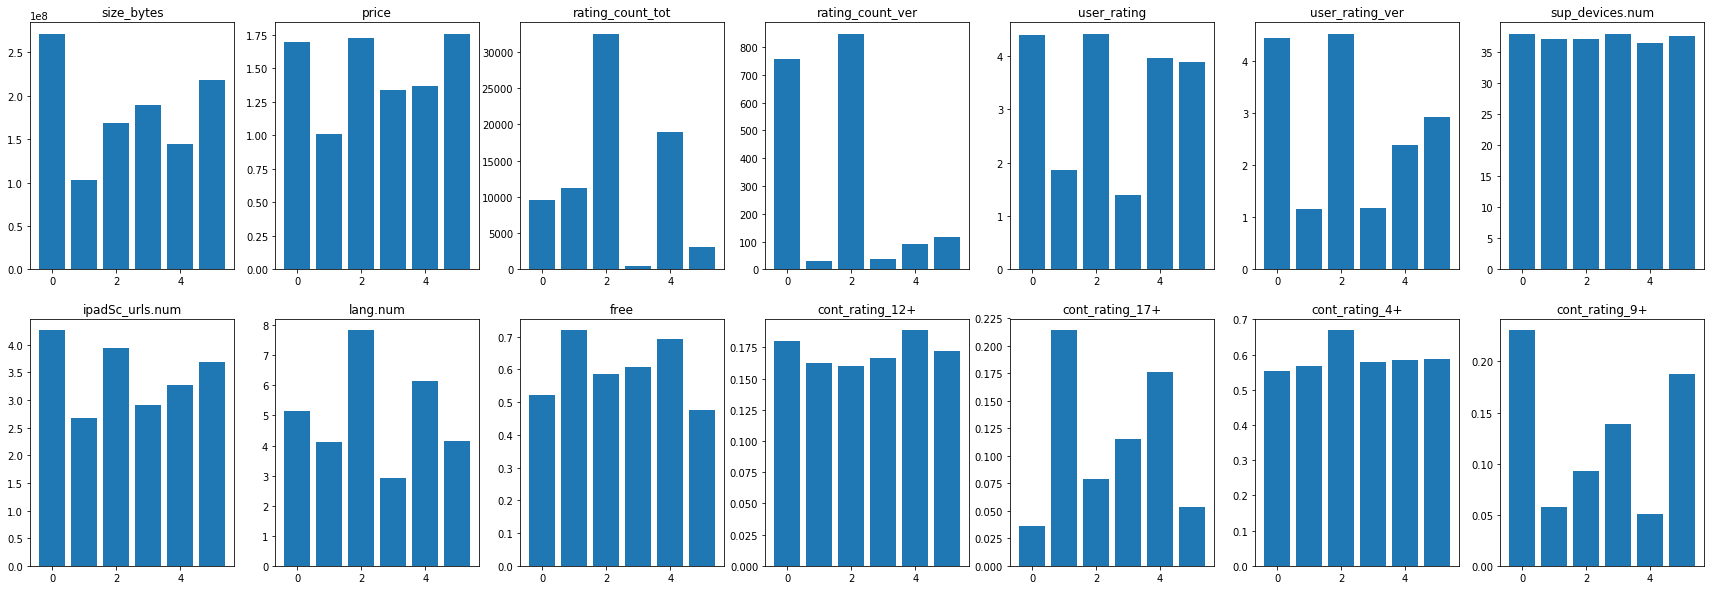

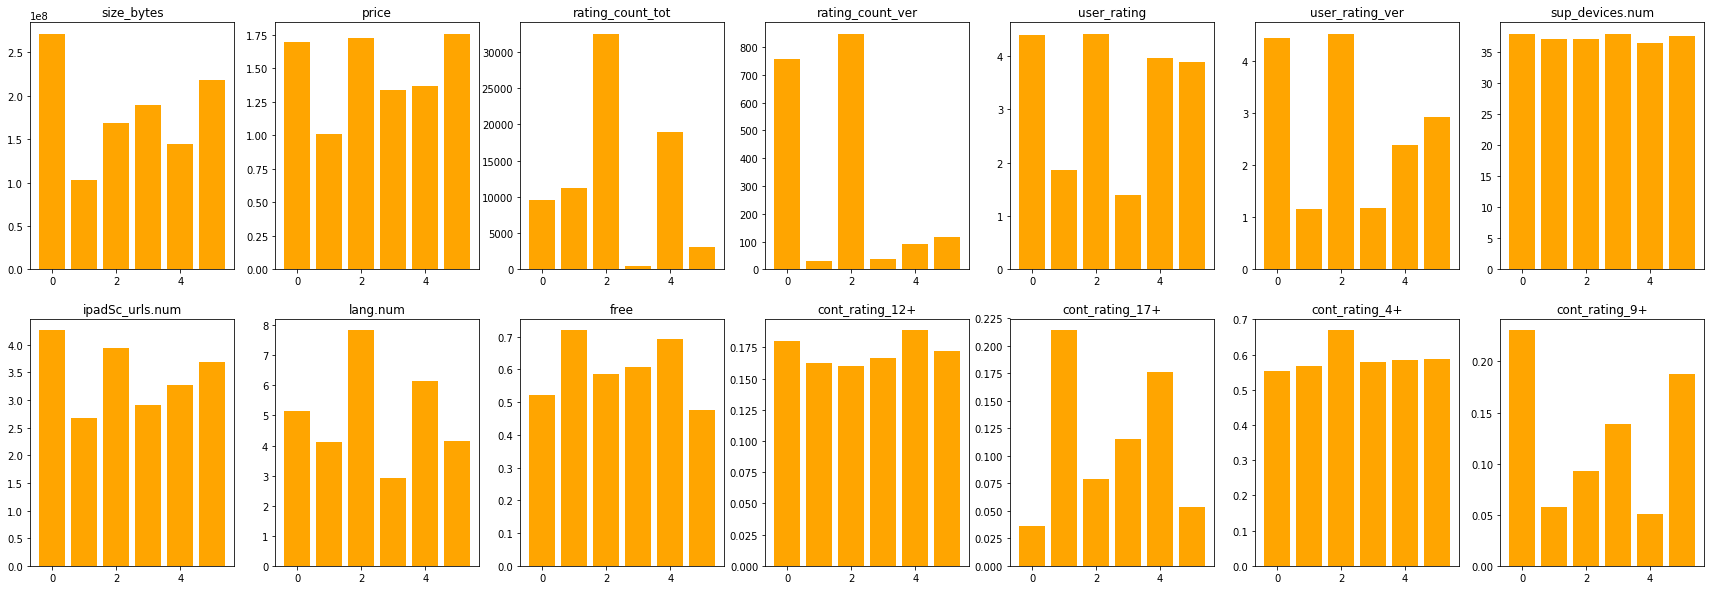

In [32]:
# MEDIANS
plt.figure(figsize=(30,10))

cols_1 = ['size_bytes', 'price', 'rating_count_tot', 'rating_count_ver', 'user_rating', 'user_rating_ver', 'sup_devices.num', 'ipadSc_urls.num',
       'lang.num', 'free', 'cont_rating_12+', 'cont_rating_17+', 'cont_rating_4+', 'cont_rating_9+']

for idx, col in enumerate(cols_1):
    plt.subplot(2, 7, idx + 1)
    plt.bar(clusters_medians_df.index, height=new_clusters_df[col])
    plt.title(col)
plt.show()

# MEANS
plt.figure(figsize=(30,10))

for idx, col in enumerate(cols_1):
    plt.subplot(2, 7, idx + 1)
    plt.bar(clusters_means_df.index, height=new_clusters_df[col], color='orange')
    plt.title(col)
plt.show()

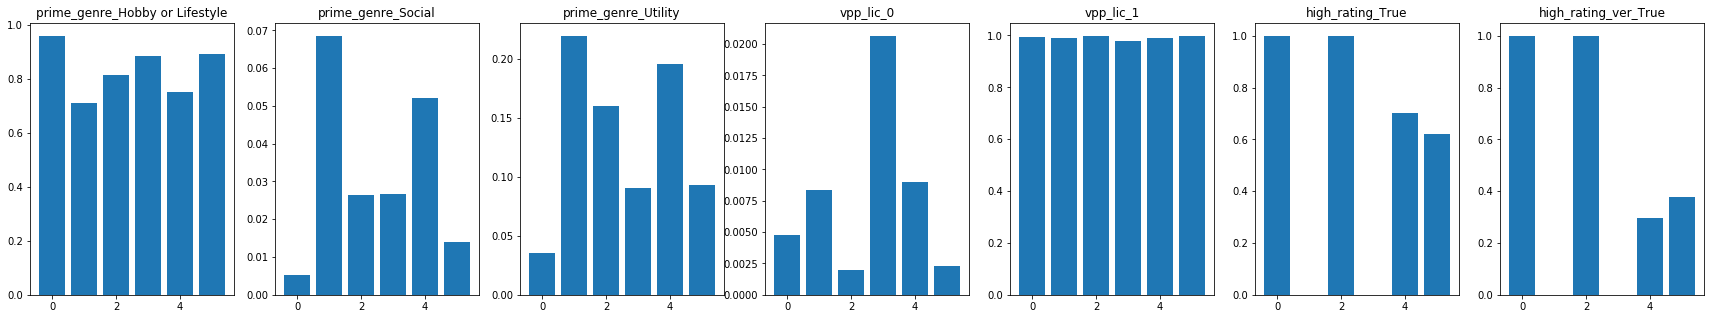

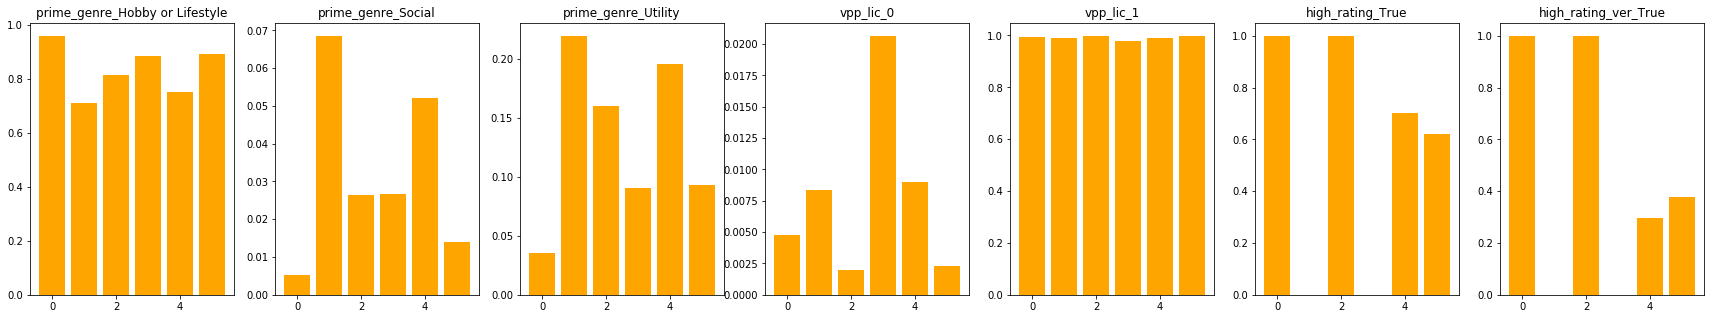

In [35]:
cols_2 = ['prime_genre_Hobby or Lifestyle', 'prime_genre_Social', 'prime_genre_Utility', 'vpp_lic_0', 'vpp_lic_1', 'high_rating_True', 'high_rating_ver_True']

# MEDIANS
plt.figure(figsize=(30,5))

for idx, col in enumerate(cols_2):
    plt.subplot(1, 7, idx + 1)
    plt.bar(clusters_medians_df.index, height=new_clusters_df[col])
    plt.title(col)
plt.show()

# MEANS
plt.figure(figsize=(30,5))

for idx, col in enumerate(cols_2):
    plt.subplot(1, 7, idx + 1)
    plt.bar(clusters_means_df.index, height=new_clusters_df[col], color='orange')
    plt.title(col)
plt.show()

In [37]:
clusters_medians_df

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,free,...,prime_genre_Social,prime_genre_Utility,vpp_lic_0,vpp_lic_1,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
0,121593856.0,0.00,474.0,81.0,4.5,4.5,38.0,5.0,1.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
1,68217856.0,0.00,32.0,0.0,2.5,0.0,37.0,4.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
2,96992256.0,0.00,3248.0,88.0,4.5,4.5,37.0,5.0,4.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,63767552.0,0.00,0.0,0.0,0.0,0.0,38.0,4.0,1.0,1.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
4,94496768.0,0.00,762.0,4.0,4.0,3.0,37.0,5.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
5,102096896.0,0.99,158.0,7.0,4.0,3.5,37.0,5.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0


In [38]:
clusters_means_df.head()

,size_bytes,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,sup_devices.num,ipadSc_urls.num,lang.num,free,...,prime_genre_Social,prime_genre_Utility,vpp_lic_0,vpp_lic_1,high_rating_False,high_rating_True,high_rating_ver_False,high_rating_ver_True,up_to_v_1_0,up_to_v_1_1
0,2.711462e+08,1.695690,9534.470178,755.421855,4.400522,4.448629,37.831084,4.259034,5.141924,0.521114,...,0.005224,0.035699,0.004789,0.995211,0.000000,1.000000,0.000000,1.000000,0.0,1.0
1,1.030968e+08,1.006979,11206.485315,31.174825,1.856643,1.154545,37.078322,2.669930,4.130070,0.718881,...,0.068531,0.219580,0.008392,0.991608,1.000000,0.000000,1.000000,0.000000,1.0,0.0
2,1.689035e+08,1.723914,32461.529373,847.361716,4.413861,4.521452,37.022442,3.941254,7.826403,0.586139,...,0.026403,0.159736,0.001980,0.998020,0.000000,1.000000,0.000000,1.000000,1.0,0.0
3,1.897887e+08,1.336859,481.525818,36.611015,1.387263,1.185456,37.784854,2.908778,2.909639,0.606713,...,0.026678,0.090361,0.020654,0.979346,1.000000,0.000000,1.000000,0.000000,0.0,1.0
4,1.439584e+08,1.368564,18881.958707,92.050269,3.972172,2.396768,36.456014,3.263914,6.149013,0.692998,...,0.052065,0.195691,0.008977,0.991023,0.298025,0.701975,0.701975,0.298025,1.0,0.0


## Conclusion

There are 6 groups in this dataset of mobile applications.

Groups 1 and 3 are the highest rated (for all versions and for most recent version). They fall mostly into the Hobby / Lifestyle genres.

Group 2 is lowly rated (for all versions and for most recent version)